In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
# Create a function to plot smoothed metric and loss curves
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [3]:
df = pd.read_pickle("Data/df_final1.pkl")

In [4]:
df_nn_cat = df.copy()

In [5]:
X = df_nn_cat.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                      "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee"]]

y = df_nn_cat["difference"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
# Scale all features using Robust Scaler
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))

In [9]:
# Create the neural network
model = Sequential()
model.add(layers.Dense(16, input_shape=(11,), activation="linear"))
model.add(layers.Dense(16, activation="linear"))
model.add(layers.Dense(16, activation="linear"))
model.add(layers.Dense(16, activation="linear"))
model.add(layers.Dense(16, activation="linear"))
model.add(layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
______________________________________________________

In [11]:
# Compile and fit the model
model.compile(optimizer="adam", loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError())
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
13322/13322 [==============================] - 12s 854us/step - loss: 3.4344 - root_mean_squared_error: 1.8532 - val_loss: 3.2045 - val_root_mean_squared_error: 1.7901
Epoch 2/15
13322/13322 [==============================] - 13s 994us/step - loss: 3.4265 - root_mean_squared_error: 1.8511 - val_loss: 3.2029 - val_root_mean_squared_error: 1.7897
Epoch 3/15
13322/13322 [==============================] - 13s 949us/step - loss: 3.4263 - root_mean_squared_error: 1.8510 - val_loss: 3.1894 - val_root_mean_squared_error: 1.7859
Epoch 4/15
13322/13322 [==============================] - 12s 876us/step - loss: 3.4252 - root_mean_squared_error: 1.8507 - val_loss: 3.1864 - val_root_mean_squared_error: 1.7850
Epoch 5/15
13322/13322 [==============================] - 11s 853us/step - loss: 3.4247 - root_mean_squared_error: 1.8506 - val_loss: 3.1873 - val_root_mean_squared_error: 1.7853
Epoch 6/15
13322/13322 [==============================] - 12s 919us/step - loss: 3.4237 - root_mean_squar

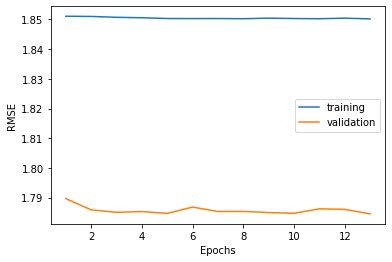

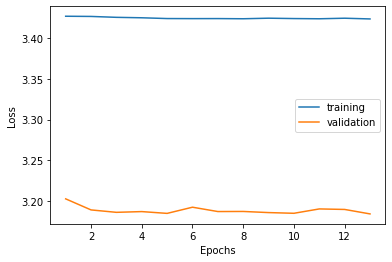

In [12]:
# Plot RMSE and loss for the training and validation sets
rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]
rmse_history = rmse_history[1:-1]
val_rmse_history = val_rmse_history[1:-1]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]
loss_history = loss_history[1:-1]
val_loss_history = val_loss_history[1:-1]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

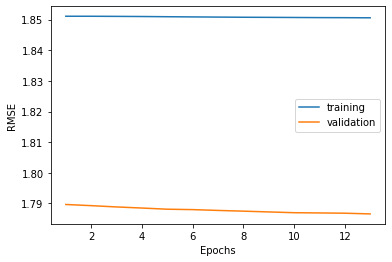

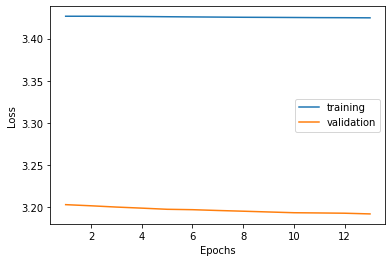

In [13]:
# Plot smoothed RMSE and loss for the training and validation sets
smooth_rmse_history = smooth_curve(rmse_history)
smooth_val_rmse_history = smooth_curve(val_rmse_history)

plt.plot(range(1, len(smooth_rmse_history) + 1), smooth_rmse_history)
plt.plot(range(1, len(smooth_val_rmse_history) + 1), smooth_val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

smooth_loss_history = smooth_curve(loss_history)
smooth_val_loss_history = smooth_curve(val_loss_history)

plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history)
plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [14]:
# Evaluate model performance on the validation set
model.evaluate(X_val, y_val)

2351/2351 [==============================] - 1s 523us/step - loss: 3.1861 - root_mean_squared_error: 1.7850


In [16]:
# Evaluate model performance on the test set
model.evaluate(X_test, y_test)

1742/1742 [==============================] - 1s 522us/step - loss: 3.3741 - root_mean_squared_error: 1.8369


In [18]:
# Create predictions for the validation and test sets
val_pred = model.predict(X_val).ravel()
test_pred = model.predict(X_test).ravel()

In [20]:
# Inverse transform the target variable and predictions for the validation and test sets
inv_val_pred = scaler.inverse_transform(val_pred.reshape(-1, 1))
inv_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

inv_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_val = mean_squared_error(inv_y_val, inv_val_pred)
mse_test = mean_squared_error(inv_y_test, inv_test_pred)

print("RMSE on validation set:", np.sqrt(mse_val))
print("RMSE on test set:", np.sqrt(mse_test))

RMSE on validation set: 21.419643
RMSE on test set: 22.042574


In [21]:
percentages = []

for idx, val in enumerate(inv_test_pred):
    perc = np.abs(val-inv_y_test[idx])/inv_y_test[idx]
    percentages.append(perc[0])

In [40]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 24.110000610351562
Mean percent error: 1.0399999618530273


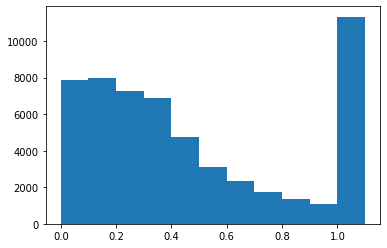

In [23]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [24]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 34731
Percentage of orders with a percent error lower than 0.5: 0.62


In [25]:
differences = []

for idx, val in enumerate(inv_y_test):
    differences.append(np.abs(val[0]-inv_test_pred[idx][0]))

In [26]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [27]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.12
Percentage of orders predicted correctly within 3 days: 0.28
Percentage of orders predicted correctly within 5 days: 0.44
Percentage of orders predicted correctly within 7 days: 0.57
